In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

In [4]:
class display_side_by_side(object):
    """Display HTML representation of multiple objects"""
    
    template = """
        <div style='float: left; padding: 10px'>
            <p style='text-align:center'>{0}</p>
            {1}
        </div>
    """

    def __init__(self, **kwargs):
        self.kwargs = kwargs

    def _repr_html_(self):
        return '\n'.join(self.template.format(name, df._repr_html_())
                     for name, df in self.kwargs.items())

    def __repr__(self):
        return '\n\n'.join(name + '\n' + repr(df)
                       for name, df in self.kwargs.items())

### checking how many null info we have

In [5]:
total_missing = lambda x: pd.DataFrame(x.isnull().sum() / x.shape[0] * 100, columns=['%'])

In [6]:
display_side_by_side(
    train=total_missing(train_data),
    test=total_missing(test_data)
)

,%
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,19.865320
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


### checking age missing and filling nan values with median

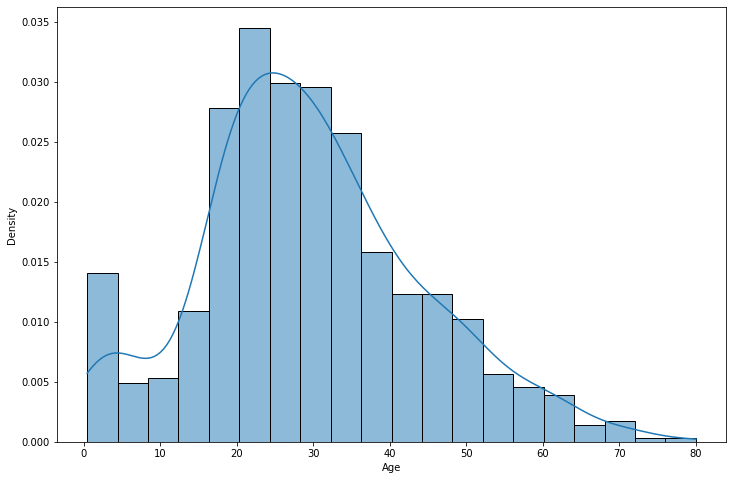

In [7]:
plt.figure(figsize=(12, 8))
sns.histplot(train_data["Age"], stat="density", kde=True)
plt.show(block=True)

In [8]:
fill_median = lambda x: x.fillna(x.median())

train_data['Age'] = fill_median(train_data['Age'])
test_data['Age'] = fill_median(test_data['Age'])

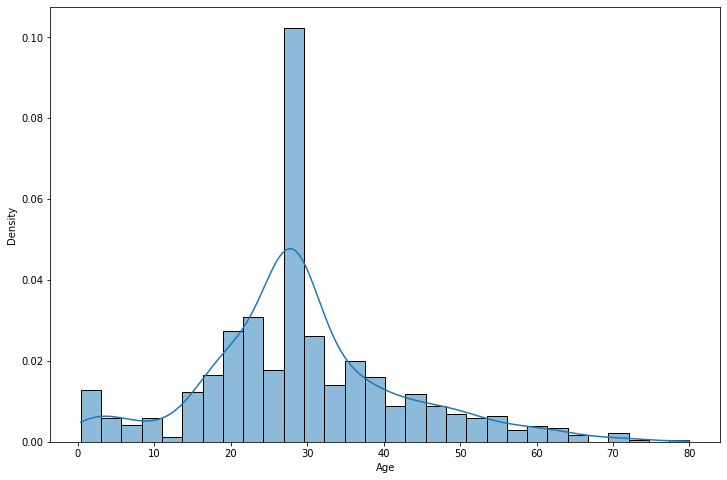

In [9]:
plt.figure(figsize=(12, 8))
sns.histplot(train_data["Age"], stat="density", kde=True)
plt.show(block=True)

### checking embarked missing on training data and filling it

In [10]:
train_data['Embarked'].isna().sum()

2

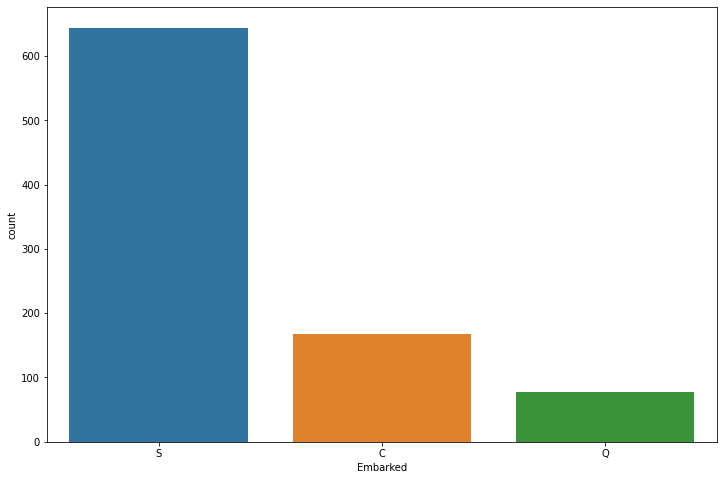

In [11]:
plt.figure(figsize=(12, 8))
sns.countplot(data=train_data, x='Embarked')
plt.show(block=True)

In [12]:
train_data['Embarked'] = train_data['Embarked'].fillna('S')

### checking fare missing on test data and filling it

In [13]:
test_data['Fare'].isna().sum()

1

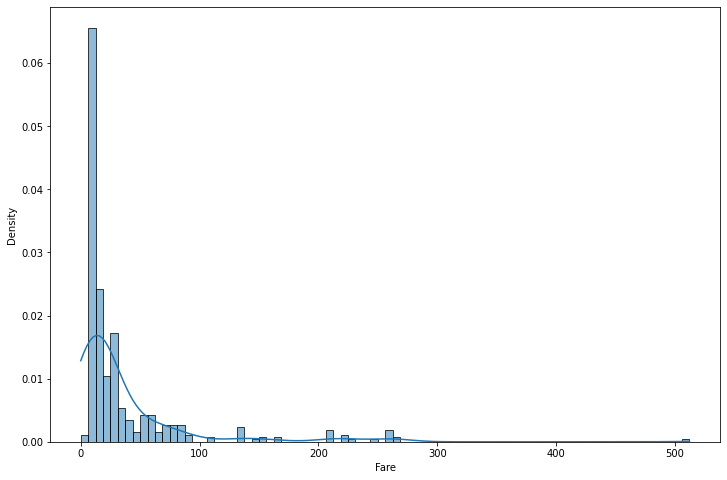

In [14]:
plt.figure(figsize=(12, 8))
sns.histplot(test_data["Fare"], stat="density", kde=True)
plt.show(block=True)

In [15]:
test_data['Fare'] = fill_median(test_data['Fare'])

In [16]:
display_side_by_side(
    train=total_missing(train_data),
    test=total_missing(test_data)
)

,%
PassengerId,0.000000
Survived,0.000000
Pclass,0.000000
Name,0.000000
Sex,0.000000
Age,0.000000
SibSp,0.000000
Parch,0.000000
Ticket,0.000000
Fare,0.000000


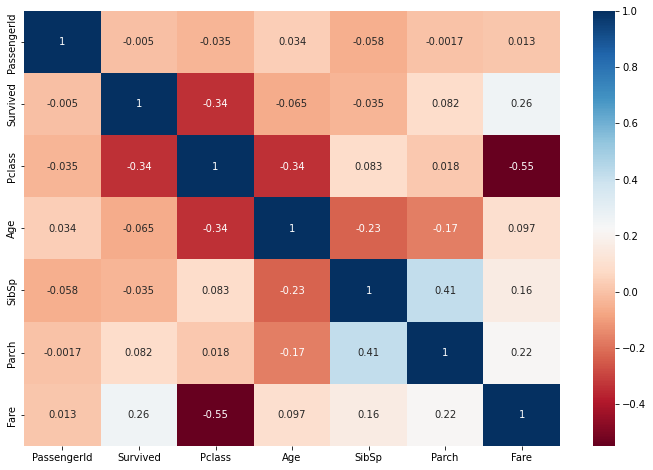

In [17]:
plt.figure(figsize=(12, 8))
sns.heatmap(train_data.corr(), cmap='RdBu', annot=True, annot_kws={'fontsize': 10})
plt.show(block=True)

### sibsp and parch can be merged as a new `family` column

In [18]:
train_data['Family'] = train_data['SibSp'] + train_data['Parch']
test_data['Family'] = train_data['SibSp'] + train_data['Parch']

### dropping unnecessary data: cabin, ticket, name, sibsp and parch

In [19]:
drop_unnecessary_cols = lambda x: x.drop(columns=['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'Age'])
train_data = drop_unnecessary_cols(train_data)
test_data = drop_unnecessary_cols(test_data)

In [20]:
display_side_by_side(train=train_data.head(), test=test_data.head())

train
   PassengerId  Survived  Pclass     Sex     Fare Embarked  Family
0            1         0       3    male   7.2500        S       1
1            2         1       1  female  71.2833        C       1
2            3         1       3  female   7.9250        S       0
3            4         1       1  female  53.1000        S       1
4            5         0       3    male   8.0500        S       0

test
   PassengerId  Pclass     Sex     Fare Embarked  Family
0          892       3    male   7.8292        Q       1
1          893       3  female   7.0000        S       1
2          894       2    male   9.6875        Q       0
3          895       3    male   8.6625        S       1
4          896       3  female  12.2875        S       0

### transforming pclass, sex and embarked with onehotencoder

In [21]:
def ohe_df_transform(df, categorical_cols):    
    transformer = make_column_transformer(
        (OneHotEncoder(), categorical_cols),
        remainder='passthrough',
        verbose_feature_names_out=False
    )
    
    transformed = transformer.fit_transform(df)
    return pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

In [22]:
train_data_ohe = ohe_df_transform(train_data, ['Embarked', 'Pclass', 'Sex'])
test_data_ohe = ohe_df_transform(test_data, ['Embarked', 'Pclass', 'Sex'])

In [23]:
train_data_ohe

,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,PassengerId,Survived,Fare,Family
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,7.2500,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,71.2833,1.0
2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,7.9250,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,4.0,1.0,53.1000,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,5.0,0.0,8.0500,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,887.0,0.0,13.0000,0.0
887,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,888.0,1.0,30.0000,0.0
888,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,889.0,0.0,23.4500,3.0
889,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,890.0,1.0,30.0000,0.0


In [24]:
test_data_ohe

,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,PassengerId,Fare,Family
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,892.0,7.8292,1.0
1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,893.0,7.0000,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,894.0,9.6875,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,895.0,8.6625,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,896.0,12.2875,0.0
...,...,...,...,...,...,...,...,...,...,...,...
413,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1305.0,8.0500,0.0
414,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1306.0,108.9000,0.0
415,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1307.0,7.2500,0.0
416,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1308.0,8.0500,2.0


### preparing for training

In [25]:
X = train_data_ohe.drop(columns=['PassengerId', 'Survived'])
y = train_data_ohe['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

### choosing model

In [44]:
model = LogisticRegression(max_iter=1000, random_state=1)#.fit(X_train, y_train)

### optimizing parameters with GridSeachCV

In [45]:
params = {
    'class_weight': ['balanced', None],
    'C': [i*0.01 for i in range(1, 100, 3)]
}

grid = GridSearchCV(estimator=model, param_grid=params, scoring='f1')
grid.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=1),
             param_grid={'C': [0.01, 0.04, 0.07, 0.1, 0.13, 0.16, 0.19, 0.22,
                               0.25, 0.28, 0.31, 0.34, 0.37, 0.4, 0.43, 0.46,
                               0.49, 0.52, 0.55, 0.58, 0.61, 0.64, 0.67,
                               0.7000000000000001, 0.73, 0.76, 0.79,
                               0.8200000000000001, 0.85, 0.88, ...],
                         'class_weight': ['balanced', None]},
             scoring='f1')

In [46]:
print(f'f1: {grid.best_score_}, params: {grid.best_params_}')
model_opt = grid.best_estimator_

f1: 0.7242490750801138, params: {'C': 0.64, 'class_weight': None}


### predicting acc value

In [47]:
y_pred = model_opt.predict(X_val)
accuracy_score(y_val, y_pred)

0.7877094972067039

In [48]:
X_test = test_data_ohe.drop(columns=['PassengerId'])
y_pred = model_opt.predict(X_test)

### submitting

In [49]:
submission = pd.DataFrame(data ={'PassengerId': test_data_ohe['PassengerId'], 'Survived': y_pred}, dtype='int')
submission.to_csv('submission.csv', index=False)